# Libraries

In [44]:
import numpy as np
from ase.io import read, write
from ase.visualize.plot import plot_atoms
import pandas as pd
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from collections import Counter
import os

# Loading dataset

The dataset comes with three xyz files. Each file contains ~36k molecules and each molecular information in a file is seperated by an empty line. Therefore, the empty lines in the files are removed and saved into new files.

In [199]:
def clean_file(data_folder='tmQM', file_suffix=['X1', 'X2', 'X3']):
    # Read the file and remove empty lines
    for x in ['X1', 'X2', 'X3']:
        print(f'Removing empty lines in tmQM_{x}.xyz file')
        with open(os.path.join(data_folder, f'tmQM_{x}.xyz'), 'r') as infile:
            lines = infile.readlines()
        
        # Filter out empty lines (including lines with only whitespace)
        non_empty_lines = [line for line in lines if line.strip()]
        
        # Write the cleaned content back to a new file (or overwrite)
        with open(os.path.join(data_folder, f'tmQM_{x}_clean.xyz'), 'w') as outfile:
            outfile.writelines(non_empty_lines)

# clean_file()

Loading a list ASE Atoms from all data.

In [46]:
def get_data(folder, file_suffix=['X1', 'X2', 'X3']):
    data = []
    for x in file_suffix:
        data += read(f'{folder}/tmQM_{x}_clean.xyz', ':')
    print('Number of data:', len(data))
    return data

# data = get_data()

In [99]:
data[0].info

{'CSD_code': 'WELROW',
 '|': True,
 'q': np.int64(0),
 'S': np.int64(0),
 'Stoichiometry': 'C40H36LaN2P3Se6',
 'MND': np.int64(8),
 '2020-2024': True,
 'CSD': True}

Adding molecular properties stored in a CSV file to ASE atoms.

In [45]:
def add_info(data, csv_file):
    df = pd.read_csv(csv_file, sep=';')
    CSD_CODE = df['CSD_code'].tolist()
    
    for tm in tqdm(data):
        csd = tm.info['CSD_code']
        info = df.iloc[CSD_CODE.index(csd)]
        info.pop('CSD_code')
        tm.info.update(info)
        tm.info['REF_energy'] = tm.info['Electronic_E'].item() * 27.2114
        tm.info['num_atoms'] = len(tm)

    return data

# data = add_info(data, 'tmQM/tmQM_y.csv')

In [105]:
data[0].info

{'CSD_code': 'WELROW',
 '|': True,
 'q': np.int64(0),
 'S': np.int64(0),
 'Stoichiometry': 'C40H36LaN2P3Se6',
 'MND': np.int64(8),
 '2020-2024': True,
 'CSD': True,
 'Electronic_E': np.float64(-17117.605212),
 'Dispersion_E': np.float64(-0.252202),
 'Dipole_M': np.float64(2.5306),
 'Metal_q': np.float64(0.43487),
 'HL_Gap': np.float64(0.12468),
 'HOMO_Energy': np.float64(-0.17887),
 'LUMO_Energy': np.float64(-0.05419),
 'Polarizability': np.float64(726.67002),
 'CSD_years': '2020-2024',
 'SMILES': nan,
 'REF_energy': -17117.605212}

In [106]:
write('tmQM/tmQM_all.xyz', data)

## Heckathon version
We choose only one file of the dataset which contains ~35k molecule for the fine tuning. Training, validation, and test sets are randomly splitted and saved.

In [47]:
data = get_data('../tmQM/tmQM/', ['X1'])
data = add_info(data, 'datasets/tmQM_y.csv')

Number of data: 34970


100%|██████████████████████████████████████████████████████████████████████████| 34970/34970 [00:34<00:00, 1018.26it/s]


Spliting dataset

In [48]:
l = int(0.1*len(data))
num = list(range(len(data)))
val_idx = random.sample(num, l)
num = [i for i in num if i not in val_idx]
test_idx = random.sample(num, l)
train_idx = [i for i in num if i not in test_idx]
len(train_idx), len(val_idx), len(test_idx)

(27976, 3497, 3497)

In [49]:
write('datasets/tmQM_X1_train.xyz', [a for i, a in enumerate(data) if i in train_idx])
write('datasets/tmQM_X1_val.xyz', [a for i, a in enumerate(data) if i in val_idx])
write('datasets/tmQM_X1_test.xyz', [a for i, a in enumerate(data) if i in test_idx])

# Visualizations

In [7]:
data = (
    read('datasets/tmQM_X1_train.xyz', ':') + 
    read('datasets/tmQM_X1_val.xyz', ':') +
    read('datasets/tmQM_X1_test.xyz', ':')
)
len(data)

34970

Creating arrays of properies and ploting histograms for 6 properties of molecules in the dataset.

In [50]:
energy = np.array([a.info['REF_energy'] for a in data])
num_atoms = np.array([len(a) for a in data])
gap = np.array([a.info['HL_Gap'] for a in data])
dipole = np.array([a.info['Dipole_M'] for a in data])
charge = np.array([a.info['Metal_q'] for a in data])
polar = np.array([a.info['Polarizability'] for a in data])
e_per_atom = energy / num_atoms

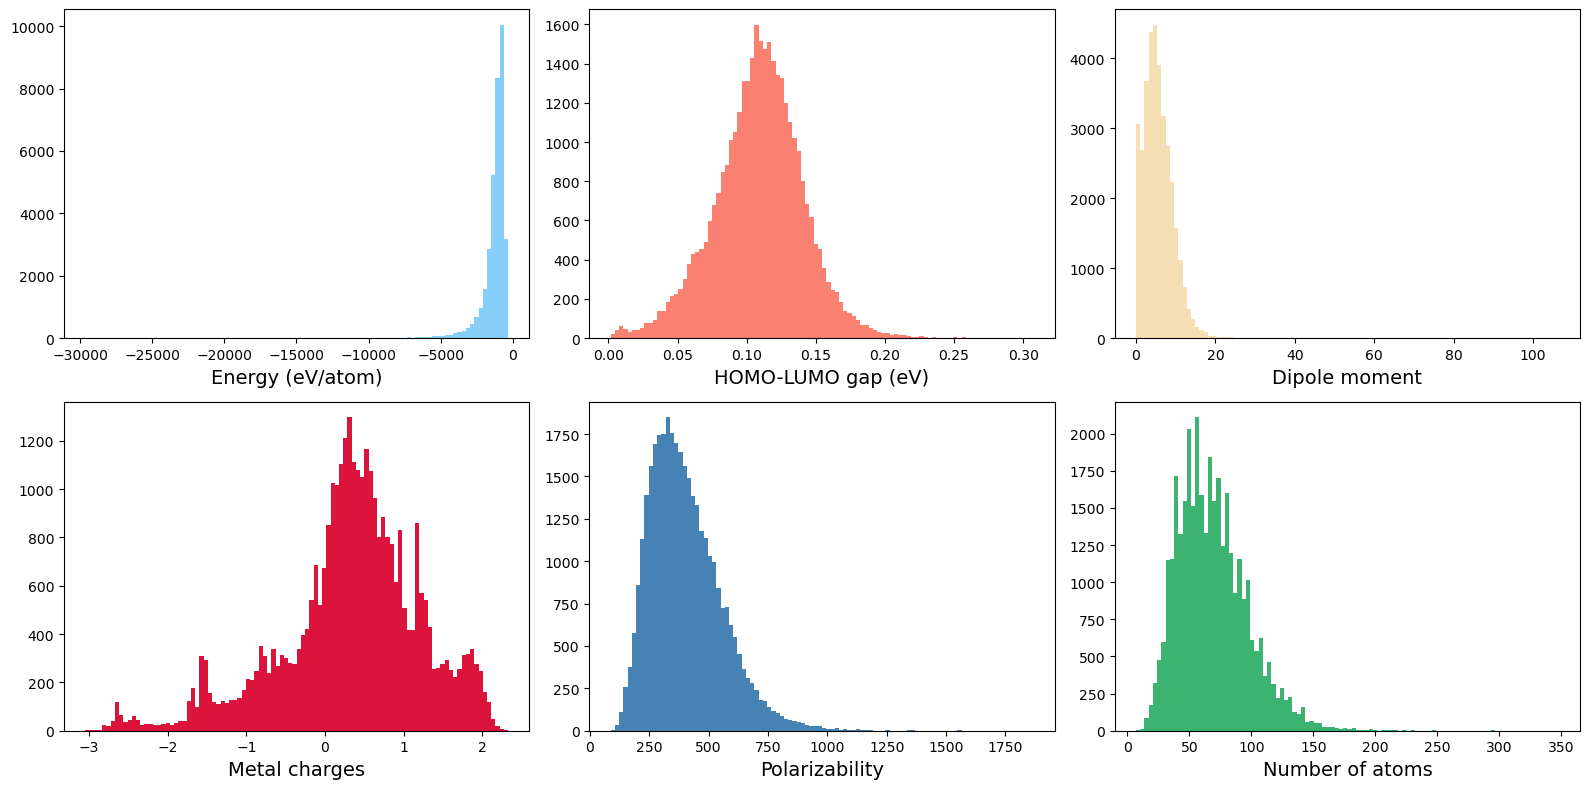

In [51]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
axs = axs.reshape(-1)
fontsize = 14
props = [e_per_atom, gap, dipole, charge, polar, num_atoms]
colors = ['lightskyblue', 'salmon', 'wheat', 'crimson', 'steelblue', 'mediumseagreen']
xlabels = ['Energy (eV/atom)', 'HOMO-LUMO gap (eV)', 'Dipole moment', 'Metal charges', 'Polarizability', 'Number of atoms']
for ax, prop, xlabel, color in zip(axs, props, xlabels, colors): 
    ax.hist(prop, bins=100, color=color)
    ax.set_xlabel(xlabel, fontsize=fontsize)
plt.tight_layout()

Text(0, 0.5, 'Energy (eV/atom)')

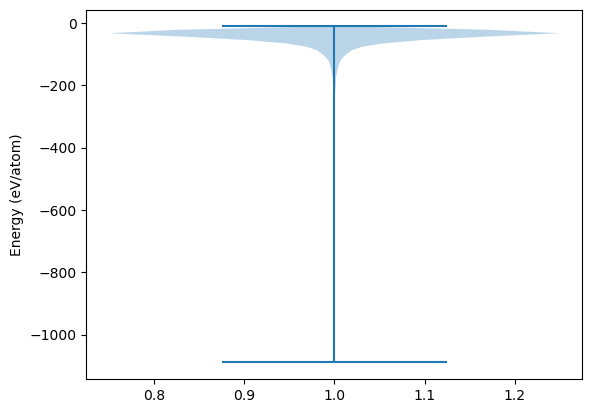

In [26]:
plt.violinplot(e_per_atom)
plt.ylabel('Energy (eV/atom)')

In [19]:
print('Number of data with E <= -200 eV/atom:', e_per_atom[e_per_atom <= -200].shape[0])
print('Number of data with E <= -400 eV/atom:', e_per_atom[e_per_atom <= -400].shape[0])

Number of data with E <= -200 eV/atom: 325
Number of data with E <= -400 eV/atom: 43


### Counting the number of elements appearing in the dataset.

In [20]:
def get_elem_count(data):
    elem_count = [set([a.symbol for a in atoms]) for atoms in data]
    elem_count = [i for a in elem_count for i in list(a)]
    elem_count = dict(Counter(elem_count))
    return elem_count

In [29]:
elem_count = get_elem_count(data)

<BarContainer object of 44 artists>

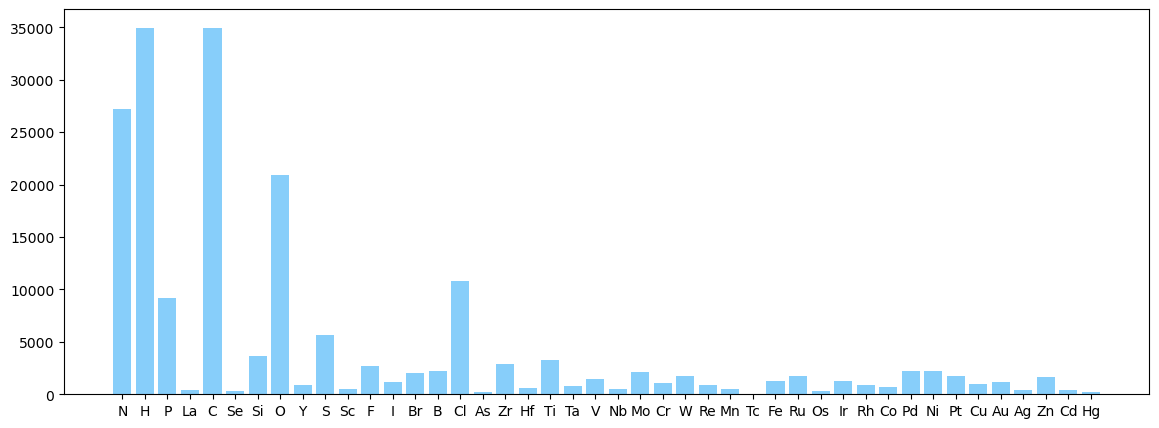

In [31]:
fig, ax = plt.subplots(figsize=(14, 5))
plt.bar(elem_count.keys(), elem_count.values(), color='lightskyblue')

### Elements appear in molecules that have energy lower than -400 eV/atom.

In [32]:
elem_count_high_e = get_elem_count([a for i, a in enumerate(data) if i in np.where(e_per_atom<=-400)[0]])

In [33]:
elem_count_low_e = get_elem_count([a for i, a in enumerate(data) if i in np.where(e_per_atom>-400)[0]])

<BarContainer object of 31 artists>

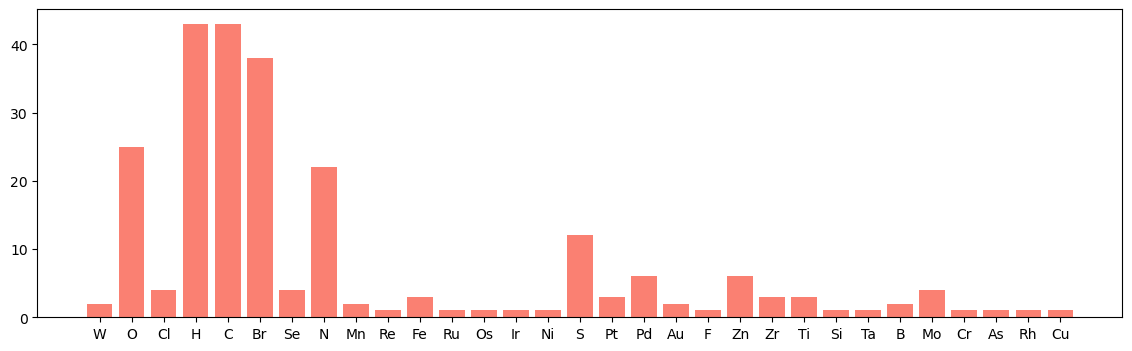

In [39]:
fig, ax = plt.subplots(figsize=(14, 4))
plt.bar(elem_count_high_e.keys(), elem_count_high_e.values(), color='salmon')

In [38]:
print('Elements appear in molecules that have E <= -400 eV/atom but not appear in E > -400 eV/atom.')
[a for a in list(elem_count_low_e.keys()) if a not in list(elem_count_high_e.keys())]

Elements appear in molecules that have E <= -400 eV/atom but not appear in E > -400 eV/atom.


['P', 'La', 'Y', 'Sc', 'I', 'Hf', 'V', 'Nb', 'Tc', 'Co', 'Ag', 'Cd', 'Hg']